# Perform submodular optimization to identify portfolio

## Import modules

In [1]:
import openml
import numpy as np
import json
import pandas as pd
import importlib
import sklearn
import string
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from utils import functions_best_setups
from utils.functions_best_setups import sub_opt, perf_imp
from plotnine import *

importlib.reload(functions_best_setups)


# set api key
openml.config.apikey = open('.key', 'r').readline().strip('\n')

In [2]:
sklearn.__version__

'0.21.2'

## Get HGB evaluation matrix

In [3]:
# get HGB evals
evals_hgb = openml.evaluations.list_evaluations('area_under_roc_curve', 
                                            uploader = [8323], 
                                            flow=[12736],
                                            output_format='dataframe')

evals_hgb.shape

(35708, 14)

In [4]:
# drop runs with insufficient number of evals on CC-18
ids = (evals_hgb.setup_id.value_counts()).index[(evals_hgb.setup_id.value_counts() >= 68)]
evals_subset_hgb = evals_hgb[evals_hgb.setup_id.isin(ids)]

# transform to wide format
evals_wide_hgb = evals_subset_hgb.pivot_table(index = 'setup_id', 
                                      columns = 'task_id', 
                                      values = 'value')


In [5]:
evals_wide_hgb = evals_wide_hgb.drop([3573, 146825, 167124], axis = 1)
evals_wide_hgb


task_id,3,6,11,12,14,15,16,18,22,23,...,146819,146820,146821,146822,146824,167119,167120,167125,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8153766,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153768,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153789,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153791,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153802,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8168895,0.840000,0.500021,0.500546,0.500000,0.500000,0.644844,0.500000,0.500000,0.500000,0.505050,...,0.520221,0.500000,0.499851,0.500000,0.500000,0.500006,0.514574,0.500218,0.500272,0.813266
8168910,0.999597,0.999704,0.980430,0.998846,0.983405,0.990940,0.998489,0.954767,0.971019,0.707143,...,0.939711,0.989274,1.000000,0.994930,0.998962,0.974505,0.521389,0.980906,0.994357,0.928592
8168921,0.999661,0.999729,0.967361,0.998572,0.983552,0.990841,0.998274,0.947665,0.955634,0.695659,...,0.942308,0.989258,0.999990,0.995286,0.998738,0.981950,0.517092,0.978584,0.994514,0.922842


## Get SVC evaluation matrix

### Get evaluations

In [6]:
# get SVC evals
evals_svc = openml.evaluations.list_evaluations('area_under_roc_curve', 
                                            uploader = [8323], 
                                            flow=[16374, 16347, 16345, 16366, 18298, 17494],
                                            output_format='dataframe')

evals_svc = evals_svc[evals_svc.upload_time>'2019-11-16 22:50:39']

In [7]:
# get evals of mixed tasks and other tasks with unmatched setup ids
mixed_tasks = [23, 29, 31, 219, 2079, 3021, 3022, 7592, 9971, 9977, 14954, 
               14965, 125920, 167125, 167141, 3, 45, 49, 3560, 14952, 
               146195, 146821, 167125, 167140, 3573]
evals_mixed_svc = evals_svc[evals_svc.task_id.isin(mixed_tasks)]
evals_mixed_svc.shape
len(evals_mixed_svc.setup_id.unique())

3331

In [8]:
# get evals of pure tasks
evals_pure_svc = evals_svc[~evals_svc.task_id.isin(mixed_tasks)]
evals_pure_svc.shape
len(evals_pure_svc.setup_id.unique())

595

### Get setups

In [9]:
# get setups of mixed tasks
setup_info_names = list(evals_mixed_svc.columns)
param_names = ['C', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape',
               'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state',
               'shrinking', 'tol', 'verbose']

setups_mixed = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_mixed_svc.iterrows():
    setup_model = openml.setups.initialize_model(i[1].setup_id)
    params = setup_model.steps[2][1].get_params().values()
    setups_mixed.loc[len(setups_mixed)] = list(i[1])+list(params)

In [10]:
# get setups of pure tasks
setups_pure = pd.DataFrame(columns = ['setup_id']+param_names)

for i in evals_pure_svc.setup_id.unique():
    setup_model = openml.setups.initialize_model(i)
    params = setup_model.steps[2][1].get_params().values()
    setups_pure.loc[len(setups_pure)] = [i]+list(params)


### Match and reassign setups to correct setup_ids

In [11]:
# match setup_ids
param_keys = ['C', 'coef0', 'degree', 'gamma', 'kernel', 'max_iter']

setups_matches = setups_mixed.merge(setups_pure, how='inner', on=param_keys)
setups_matches.rename(columns={'setup_id_y':'setup_id'}, inplace=True)

In [12]:
evals_mixed_final = setups_matches

### Recreate evaluation matrix with matched setups

In [13]:
# merge pure and mixed setups
evals_svc = evals_pure_svc.append(evals_mixed_final)

In [14]:
# drop runs with insufficient number of evals on CC-18
ids = (evals_svc.setup_id.value_counts()).index[(evals_svc.setup_id.value_counts() >= 30)]
evals_subset_svc = evals_svc[evals_svc.setup_id.isin(ids)]

# transform to wide format
evals_wide_svc = evals_subset_svc.pivot_table(index = 'setup_id', 
                                      columns = 'task_id', 
                                      values = 'value')

In [15]:
evals_wide_svc

task_id,3,6,11,12,14,15,16,18,22,23,...,146817,146819,146820,146821,146822,146824,167119,167120,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8255509,0.979148,0.989495,0.981979,0.999275,0.980622,0.994573,0.998110,NaN,NaN,0.693388,...,0.902443,0.952077,0.991964,0.979154,0.974699,0.999370,NaN,NaN,0.993549,0.880809
8255510,0.986995,0.993091,0.980991,0.999125,0.982386,0.994972,0.997976,0.960343,NaN,0.682877,...,0.902759,0.949613,0.985389,0.987057,0.980924,0.998829,NaN,NaN,0.990846,0.883022
8255511,0.999868,NaN,0.999104,0.950226,NaN,NaN,NaN,NaN,NaN,NaN,...,0.919777,0.925189,0.993476,1.000000,0.992367,0.524062,NaN,NaN,0.735101,0.888077
8255513,0.990997,0.995431,0.987158,0.999425,0.981152,0.994582,0.999211,0.958083,NaN,0.721782,...,0.915162,0.949503,0.992449,0.982903,0.980378,0.999548,NaN,NaN,0.994394,0.887175
8255514,0.989217,0.993589,0.981123,0.999137,0.981871,0.994981,0.997771,0.961297,NaN,0.682734,...,0.903286,0.952561,0.985148,0.983359,0.981547,0.998824,NaN,NaN,0.989646,0.882811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8255934,0.920700,NaN,0.964759,0.997585,0.963252,NaN,0.993484,NaN,NaN,0.687027,...,0.881620,0.950713,0.765970,0.977946,0.941302,0.997845,NaN,NaN,0.986687,0.748707
8255938,0.990832,0.994135,0.980422,0.999124,0.981244,0.995053,0.997768,0.966006,0.986707,0.684563,...,0.904997,0.952781,0.978551,0.987186,0.983655,0.998746,0.785172,NaN,0.984533,0.581293
8255939,0.991260,0.997457,0.953448,0.493664,0.489772,0.977631,0.497107,0.963570,0.538000,0.577637,...,0.875179,0.430228,0.960503,0.996390,0.988708,0.495350,0.898225,NaN,0.615992,0.412310


# Get RF evaluation matrix

### Get evaluations

In [16]:
# get SVC evals
evals_rf = openml.evaluations.list_evaluations('area_under_roc_curve', 
                                            uploader = [8323], 
                                            flow=[8351, 17651, 17652, 17653,17654, 17655,
                                                  17656, 17657, 17658, 17691, 17692],
                                            output_format='dataframe')

evals_rf = evals_rf[evals_rf.upload_time>'2020-01-01 22:50:39']

In [17]:
# get evals of mixed tasks and other tasks with unmatched setup ids
mixed_tasks = [23, 29, 31, 219, 2079, 3021, 3022, 7592, 9971, 9977, 14954, 
               14965, 125920, 167125, 167141, 3, 45, 49, 3560, 14952, 146195, 
               146821, 167125, 167140, 3573]
evals_mixed_rf = evals_rf[evals_rf.task_id.isin(mixed_tasks)]
evals_mixed_rf.shape
len(evals_mixed_rf.setup_id.unique())

3175

In [18]:
# get evals of pure tasks
#ids = (evals_svc.setup_id.value_counts()).index[(evals_svc.setup_id.value_counts() >= 19)]
evals_pure_rf = evals_rf[~evals_rf.task_id.isin(mixed_tasks)]
evals_pure_rf.shape
len(evals_pure_rf.setup_id.unique())

466

### Get setups

In [19]:
# get setups of mixed tasks
setup_info_names = list(evals_mixed_rf.columns)
param_names = ['bootstrap', 'class_weight', 'criterion', 'max_depth', 
               'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 
               'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 
               'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 
               'oob_score', 'random_state', 'verbose', 'warm_start']

setups_mixed = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_mixed_rf.iterrows():
    try:
        setup_model = openml.setups.initialize_model(i[1].setup_id)
        params = setup_model.steps[2][1].get_params().values()
        setups_mixed.loc[len(setups_mixed)] = list(i[1])+list(params)
    except Exception as e:
        print(e)

Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.

Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.

In [20]:
# get setups of pure tasks
setup_info_names = ['setup_id']
setups_pure = pd.DataFrame(columns = setup_info_names+param_names)

for i in evals_pure_rf.setup_id.unique():
    try:
        setup_model = openml.setups.initialize_model(i)
        params = setup_model.steps[2][1].get_params().values()
        setups_pure.loc[len(setups_pure)] = [i]+list(params)
    except Exception as e:
        print(e)


Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.

Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.
Trying to deserialize a model with dependency sklearn==0.22.1 not satisfied.

### Match and reassign setups to correct setup_ids

In [21]:
# match setup_ids
param_keys = ['max_depth', 'max_features', 'max_leaf_nodes',
               'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 
               'min_weight_fraction_leaf', 'n_estimators']

setups_matches = setups_mixed.merge(setups_pure, how='inner', on=param_keys)
setups_matches.rename(columns={'setup_id_y':'setup_id'}, inplace=True)

In [22]:
evals_mixed_final = setups_matches

### Recreate evaluation matrix with matched setups

In [23]:
# merge pure and mixed setups
evals_rf = evals_pure_rf.append(evals_mixed_final)

In [24]:
# drop runs with insufficient number of evals on CC-18
ids = (evals_rf.setup_id.value_counts()).index[(evals_rf.setup_id.value_counts() >= 30)]
evals_subset_rf = evals_rf[evals_rf.setup_id.isin(ids)]

# transform to wide format
evals_wide_rf = evals_subset_rf.pivot_table(index = 'setup_id', 
                                      columns = 'task_id', 
                                      values = 'value')

In [25]:
evals_wide_rf

task_id,3,6,11,12,14,15,16,18,22,23,...,146817,146819,146820,146821,146822,146824,167119,167120,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8261487,0.998087,0.995934,0.926366,0.995869,0.967540,0.987860,0.987469,0.935913,0.938442,0.678605,...,0.918474,0.813237,0.964502,0.993580,0.992057,0.994838,0.909935,0.506147,0.984075,0.906524
8261494,0.999845,0.999605,0.921634,0.998238,0.983050,0.991555,0.997632,0.956512,0.957962,0.709890,...,0.946693,0.906547,0.987845,0.999170,0.995108,0.998649,0.947693,NaN,0.990398,0.912012
8261509,0.999400,0.999539,0.926493,0.998437,0.984318,0.992743,0.998242,0.959687,0.969771,0.716755,...,0.941658,0.911151,0.987178,0.998174,0.995802,0.999036,0.941555,0.518011,0.992909,0.913303
8261514,0.999863,0.999620,0.919052,0.998051,0.983242,0.992553,0.997474,0.954910,0.952303,0.705385,...,0.945893,0.918364,0.983701,0.999236,0.995714,0.998801,0.947017,0.514251,0.991344,0.909095
8261516,0.989970,0.929470,0.940218,0.996920,0.974587,0.988621,0.993379,0.956808,0.964933,0.673004,...,0.891836,0.911063,0.498101,0.936902,0.986532,0.995837,0.828700,0.499967,0.991569,0.854782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8262202,0.980597,0.995831,0.941459,0.995919,0.963724,0.991257,0.991264,0.959298,0.967827,0.702721,...,0.915645,0.893505,0.986524,0.989442,0.990501,0.993985,0.948118,0.526063,0.981142,0.891179
8262208,0.999260,0.998245,0.949219,0.997886,0.981075,0.992788,0.994922,0.960218,0.968115,0.727327,...,0.945015,0.928578,0.992292,0.997315,0.994450,0.996282,0.964662,0.516366,0.988140,0.917167
8262236,0.998926,0.999322,0.921400,0.998683,0.983361,0.993359,0.998033,0.956499,0.962872,0.674099,...,0.936250,0.891084,0.987149,0.996676,0.995704,0.999172,0.933631,0.519800,0.993847,0.914274


## Merge HGB, SVC and RF data 

In [26]:
evals_wide_merged = pd.concat([evals_wide_hgb, evals_wide_svc, evals_wide_rf])
evals_wide_merged

task_id,3,6,11,12,14,15,16,18,22,23,...,146819,146820,146821,146822,146824,167119,167120,167125,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8153766,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153768,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153789,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153791,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
8153802,0.999716,0.999721,0.969933,0.998811,0.983606,0.991538,0.998473,0.957119,0.965566,0.708021,...,0.943056,0.990106,0.999998,0.995578,0.998918,0.976242,0.522143,0.982444,0.994517,0.923335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8262202,0.980597,0.995831,0.941459,0.995919,0.963724,0.991257,0.991264,0.959298,0.967827,0.702721,...,0.893505,0.986524,0.989442,0.990501,0.993985,0.948118,0.526063,NaN,0.981142,0.891179
8262208,0.999260,0.998245,0.949219,0.997886,0.981075,0.992788,0.994922,0.960218,0.968115,0.727327,...,0.928578,0.992292,0.997315,0.994450,0.996282,0.964662,0.516366,NaN,0.988140,0.917167
8262236,0.998926,0.999322,0.921400,0.998683,0.983361,0.993359,0.998033,0.956499,0.962872,0.674099,...,0.891084,0.987149,0.996676,0.995704,0.999172,0.933631,0.519800,NaN,0.993847,0.914274


In [27]:
evals_wide_svc = evals_wide_merged.loc[evals_wide_svc.index,:]

# empty list for indices of missing values
missing = []

for i in evals_wide_svc.columns:
    for j in evals_wide_svc.index:
        
        coordinates = (j, i)
        
        value = evals_wide_svc.at[coordinates]

        if np.isnan(value):
            missing.append(coordinates)
            
missing = pd.DataFrame(missing, columns=['setup_id', 'task_id'])
missing.to_csv('svc_missing.csv')
missing.groupby('task_id').count()

evals_wide_svc.isna().sum().sum() / np.prod(evals_wide_svc.shape)

0.15490196078431373

In [28]:
evals_wide_rf = evals_wide_merged.loc[evals_wide_rf.index,:]

# empty list for indices of missing values
missing = []

for i in evals_wide_rf.columns:
    for j in evals_wide_rf.index:
        
        coordinates = (j, i)
        
        value = evals_wide_rf.at[coordinates]

        if np.isnan(value):
            missing.append(coordinates)
            
missing = pd.DataFrame(missing, columns=['setup_id', 'task_id'])
missing.to_csv('rf_missing.csv')
missing.groupby('task_id').setup_id.count()

evals_wide_rf.isna().sum().sum() / np.prod(evals_wide_rf.shape)

0.06404174573055028

## Clean merged data

In [29]:
evals_wide_merged[evals_wide_merged < 0.5] = np.nan

## Standardize merged data

In [31]:
evals_wide_merged.loc[len(evals_wide_merged)] = 0.5

evals_merged_std = pd.DataFrame(MinMaxScaler().fit_transform(X = evals_wide_merged), 
                               index= evals_wide_merged.index,
                               columns = evals_wide_merged.columns)

evals_wide_merged = evals_wide_merged.drop(evals_wide_merged.index[-1], axis=0)
evals_merged_std = evals_merged_std.drop(evals_merged_std.index[-1], axis=0)
evals_merged_std = evals_merged_std.fillna(0)

In [32]:
evals_svc_std = evals_merged_std.loc[evals_wide_svc.index,:]
evals_hgb_std = evals_merged_std.loc[evals_wide_hgb.index,:]
evals_rf_std = evals_merged_std.loc[evals_wide_rf.index,:]

## Rank merged data

In [33]:
evals_merged_rank = evals_merged_std.rank(method='max')

evals_merged_rank = pd.DataFrame(MinMaxScaler().fit_transform(X = evals_merged_rank), 
                               index = evals_merged_rank.index,
                               columns = evals_merged_rank.columns)

evals_svc_rank = evals_merged_rank.loc[evals_wide_svc.index,:]
evals_hgb_rank = evals_merged_rank.loc[evals_wide_hgb.index,:]
evals_rf_rank = evals_merged_rank.loc[evals_wide_rf.index,:]

In [35]:
evals_merged_rank

task_id,3,6,11,12,14,15,16,18,22,23,...,146819,146820,146821,146822,146824,167119,167120,167125,167140,167141
setup_id,,,,,,,,,,,,,,,,,,,,,
8153766,0.805164,0.907862,0.490588,0.674389,0.785340,0.525998,0.756510,0.387863,0.330612,0.580606,...,0.717604,0.683951,0.871671,0.872050,0.680210,0.834395,0.700183,0.97479,0.866189,0.881643
8153768,0.805164,0.907862,0.490588,0.674389,0.785340,0.525998,0.756510,0.387863,0.330612,0.580606,...,0.717604,0.683951,0.871671,0.872050,0.680210,0.834395,0.700183,0.97479,0.866189,0.881643
8153789,0.805164,0.907862,0.490588,0.674389,0.785340,0.525998,0.756510,0.387863,0.330612,0.580606,...,0.717604,0.683951,0.871671,0.872050,0.680210,0.834395,0.700183,0.97479,0.866189,0.881643
8153791,0.805164,0.907862,0.490588,0.674389,0.785340,0.525998,0.756510,0.387863,0.330612,0.580606,...,0.717604,0.683951,0.871671,0.872050,0.680210,0.834395,0.700183,0.97479,0.866189,0.881643
8153802,0.805164,0.907862,0.490588,0.674389,0.785340,0.525998,0.756510,0.387863,0.330612,0.580606,...,0.717604,0.683951,0.871671,0.872050,0.680210,0.834395,0.700183,0.97479,0.866189,0.881643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8262202,0.105634,0.314496,0.287059,0.087516,0.087696,0.465538,0.098958,0.554090,0.387755,0.486061,...,0.151589,0.343210,0.234867,0.336646,0.095675,0.468153,0.839122,0.00000,0.143369,0.301932
8262208,0.484742,0.409091,0.382353,0.191763,0.339005,0.719468,0.149740,0.609499,0.401361,0.785455,...,0.394866,0.859259,0.435835,0.568944,0.123198,0.681529,0.361974,0.00000,0.230585,0.707729
8262236,0.406103,0.567568,0.127059,0.619048,0.722513,0.818622,0.559896,0.336412,0.259864,0.196364,...,0.143032,0.404938,0.405569,0.903106,0.866317,0.292994,0.592322,0.00000,0.623656,0.607488


In [36]:
evals_merged_rank.describe()

task_id,3,6,11,12,14,15,16,18,22,23,...,146819,146820,146821,146822,146824,167119,167120,167125,167140,167141
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,...,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,0.497249,0.474992,0.496055,0.453516,0.445870,0.483007,0.448249,0.442412,0.428963,0.481448,...,0.477649,0.472737,0.485715,0.469759,0.445455,0.366702,0.319416,0.209075,0.488434,0.483217
std,0.290881,0.302305,0.291473,0.311576,0.314328,0.298779,0.313484,0.315490,0.319819,0.299122,...,0.301390,0.303346,0.304709,0.304728,0.314543,0.332197,0.333599,0.309586,0.295622,0.298247
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.245599,0.210381,0.244118,0.172780,0.158704,0.223700,0.163086,0.152045,0.125510,0.220909,...,0.214242,0.206790,0.221852,0.201553,0.157602,0.000000,0.000000,0.000000,0.232079,0.223732
50%,0.497066,0.473587,0.495882,0.448520,0.439136,0.482467,0.442057,0.434697,0.417007,0.480606,...,0.477995,0.470988,0.481235,0.467702,0.438401,0.317675,0.216636,0.000000,0.488053,0.482488
75%,0.748533,0.736794,0.747941,0.724260,0.719568,0.740931,0.721029,0.718338,0.708503,0.740303,...,0.738386,0.735494,0.740617,0.733851,0.719528,0.658838,0.608318,0.399860,0.744026,0.741244
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Submodular optimization AUC (min-max scaled, mean)

In [48]:
def eval_order(evals, order_id=False):
        
    if order_id==True:
        order_setups = np.argsort(evals.index)
        order_tasks = np.argsort(evals.columns)
        
    else:                 
        order_setups = np.argsort(evals.mean(axis = 1))
        order_tasks = np.argsort(evals.mean(axis = 0))
        
    evals_ordered = evals.iloc[order_setups, order_tasks]
    
    return evals_ordered

In [54]:
evals_wide_ordered = eval_order(evals_merged_rank)

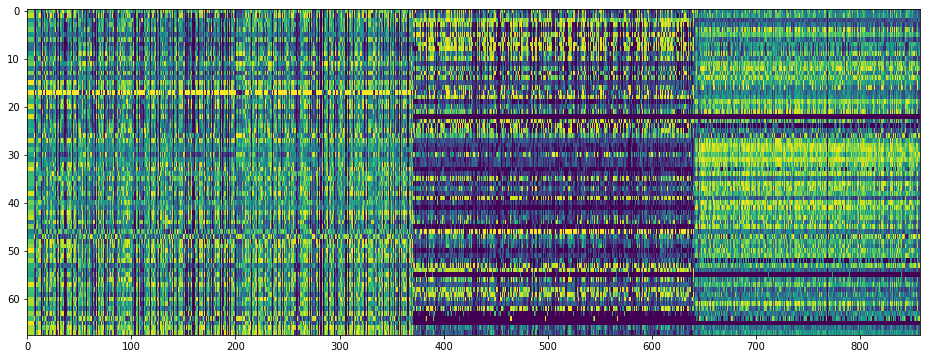

In [55]:
plt.figure(figsize = (16, 6))
plt.imshow(evals_merged_rank.T, aspect = 'auto')

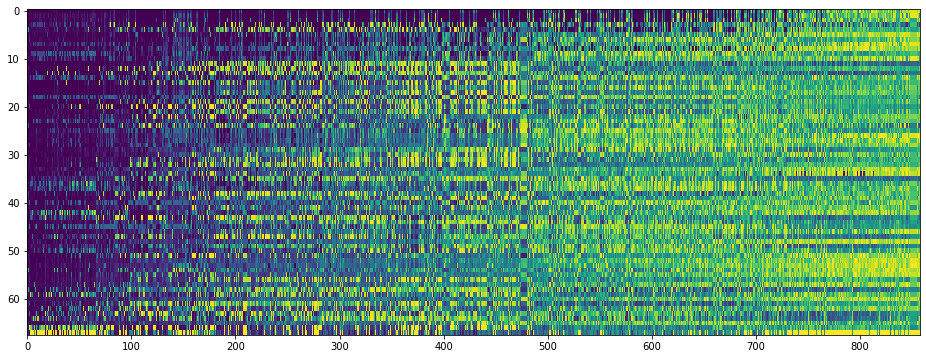

In [56]:
plt.figure(figsize = (16, 6))
plt.imshow(evals_wide_ordered.T, aspect = 'auto')

# Compare performance

## Standardized mean

In [57]:
setup_id, pp_merged_mean_std, pp_merged_sem_std = perf_imp(evals_merged_std, evals_merged_std, 
                                                           criterion='mean', ranking='min')
setup_id, pp_hgb_mean_std, pp_hgb_sem_std = perf_imp(evals_hgb_std, evals_hgb_std,
                                                    criterion='mean', ranking='min')
setup_id, pp_svc_mean_std, pp_svc_sem_std = perf_imp(evals_svc_std, evals_svc_std,
                                                    criterion='mean', ranking='min')
setup_id, pp_rf_mean_std, pp_rf_sem_std = perf_imp(evals_rf_std, evals_rf_std,
                                                  criterion='mean', ranking='min')

In [58]:
merged_std_u = [i + j for i, j in zip(pp_merged_mean_std[0:50], pp_merged_sem_std[0:50])]
merged_std_l = [i - j for i, j in zip(pp_merged_mean_std[0:50], pp_merged_sem_std[0:50])]
hgb_std_u = [i + j for i, j in zip(pp_hgb_mean_std[0:50], pp_hgb_sem_std[0:50])]
hgb_std_l = [i - j for i, j in zip(pp_hgb_mean_std[0:50], pp_hgb_sem_std[0:50])]
svc_std_u = [i + j for i, j in zip(pp_svc_mean_std[0:50], pp_svc_sem_std[0:50])]
svc_std_l = [i - j for i, j in zip(pp_svc_mean_std[0:50], pp_svc_sem_std[0:50])]
rf_std_u = [i + j for i, j in zip(pp_rf_mean_std[0:50], pp_rf_sem_std[0:50])]
rf_std_l = [i - j for i, j in zip(pp_rf_mean_std[0:50], pp_rf_sem_std[0:50])]

''

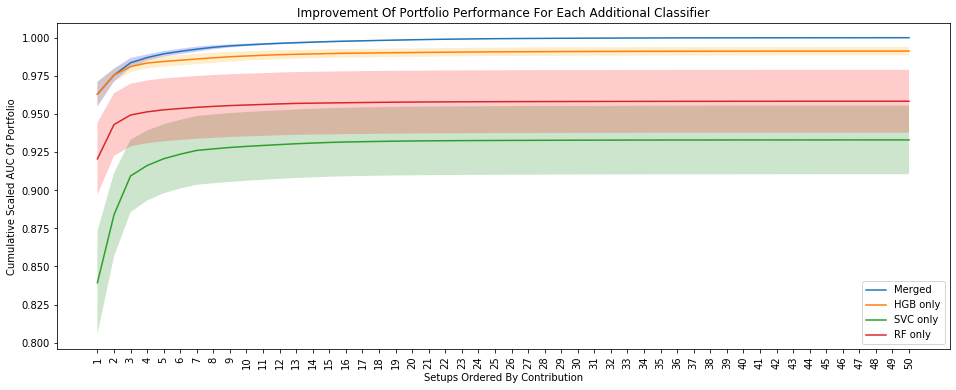

In [59]:
ax1 = pd.Series(pp_merged_mean_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_hgb_mean_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_svc_mean_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_rf_mean_std[0:50]).plot(figsize = (16,6), xticks=range(50))


ax1.fill_between(range(0,50), merged_std_u, merged_std_l, alpha=0.2, facecolor='blue')
ax1.fill_between(range(0,50), hgb_std_u, hgb_std_l, alpha=0.2, facecolor='orange')
ax1.fill_between(range(0,50), svc_std_u, svc_std_l, alpha=0.2, facecolor='green')
ax1.fill_between(range(0,50), rf_std_u, rf_std_l, alpha=0.2, facecolor='red')


ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only', 'RF only'])
ax1.set_yscale('linear')
ax1.set_ylabel('Cumulative Scaled AUC Of Portfolio')
ax1.set_xlabel('Setups Ordered By Contribution')
ax1.set_title('Improvement Of Portfolio Performance For Each Additional Classifier')
;

''

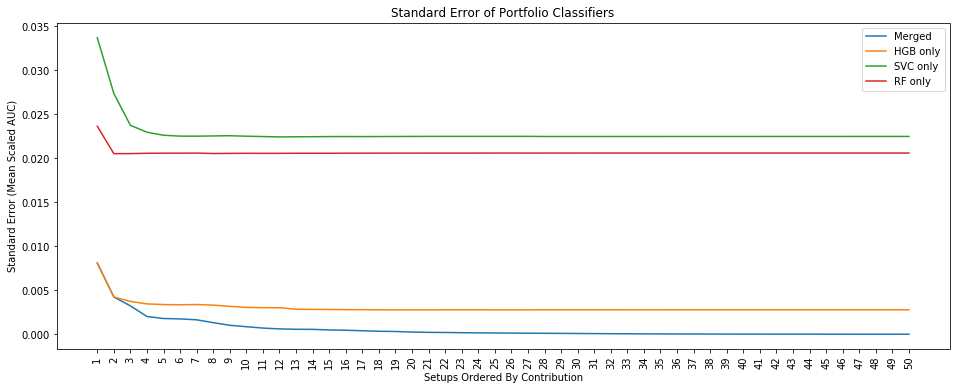

In [60]:
ax1 = pd.Series(pp_merged_sem_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_hgb_sem_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_svc_sem_std[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_rf_sem_std[0:50]).plot(figsize = (16,6), xticks=range(50))


ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only', 'RF only'])
ax1.set_yscale('linear')
ax1.set_ylabel('Standard Error (Mean Scaled AUC)')
ax1.set_xlabel('Setups Ordered By Contribution')
ax1.set_title('Standard Error of Portfolio Classifiers')
;

## Ranked mean

In [61]:
setup_id, pp_merged_mean_rank, pp_merged_sem_rank = perf_imp(evals_merged_rank, evals_merged_rank,
                                                            criterion='mean', ranking='min')
setup_id, pp_hgb_mean_rank, pp_hgb_sem_rank = perf_imp(evals_hgb_rank, evals_hgb_rank,
                                                      criterion='mean', ranking='min')
setup_id, pp_svc_mean_rank, pp_svc_sem_rank = perf_imp(evals_svc_rank, evals_svc_rank,
                                                      criterion='mean', ranking='min')
setup_id, pp_rf_mean_rank, pp_rf_sem_rank = perf_imp(evals_rf_rank, evals_rf_rank,
                                                     criterion='mean', ranking='min')

In [62]:
merged_rank_u = [i + j for i, j in zip(pp_merged_mean_rank[0:50], pp_merged_sem_rank[0:50])]
merged_rank_l = [i - j for i, j in zip(pp_merged_mean_rank[0:50], pp_merged_sem_rank[0:50])]
hgb_rank_u = [i + j for i, j in zip(pp_hgb_mean_rank[0:50], pp_hgb_sem_rank[0:50])]
hgb_rank_l = [i - j for i, j in zip(pp_hgb_mean_rank[0:50], pp_hgb_sem_rank[0:50])]
svc_rank_u = [i + j for i, j in zip(pp_svc_mean_rank[0:50], pp_svc_sem_rank[0:50])]
svc_rank_l = [i - j for i, j in zip(pp_svc_mean_rank[0:50], pp_svc_sem_rank[0:50])]
rf_rank_u = [i + j for i, j in zip(pp_rf_mean_rank[0:50], pp_rf_sem_rank[0:50])]
rf_rank_l = [i - j for i, j in zip(pp_rf_mean_rank[0:50], pp_rf_sem_rank[0:50])]

''

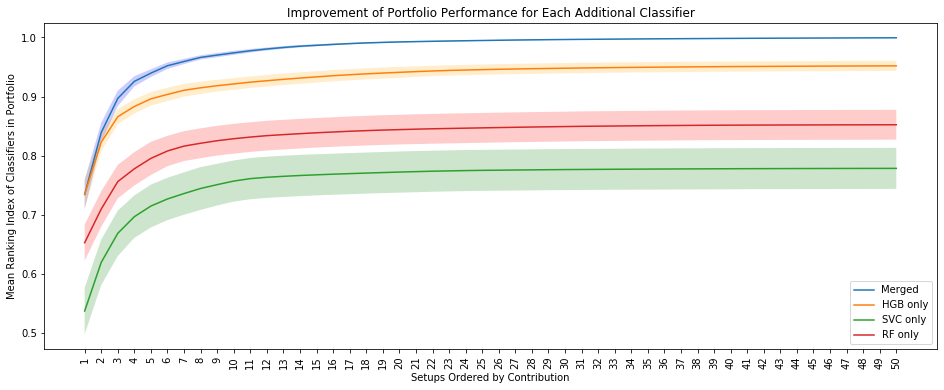

In [63]:
ax1 = pd.Series(pp_merged_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_hgb_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_svc_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_rf_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))


ax1.fill_between(range(0,50), merged_rank_u, merged_rank_l, alpha=0.2, facecolor='blue')
ax1.fill_between(range(0,50), hgb_rank_u, hgb_rank_l, alpha=0.2, facecolor='orange')
ax1.fill_between(range(0,50), svc_rank_u, svc_rank_l, alpha=0.2, facecolor='green')
ax1.fill_between(range(0,50), rf_rank_u, rf_rank_l, alpha=0.2, facecolor='red')


ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only', 'RF only'])
ax1.set_yscale('linear')
ax1.set_ylabel('Mean Ranking Index of Classifiers in Portfolio')
ax1.set_xlabel('Setups Ordered by Contribution')
ax1.set_title('Improvement of Portfolio Performance for Each Additional Classifier')
;

''

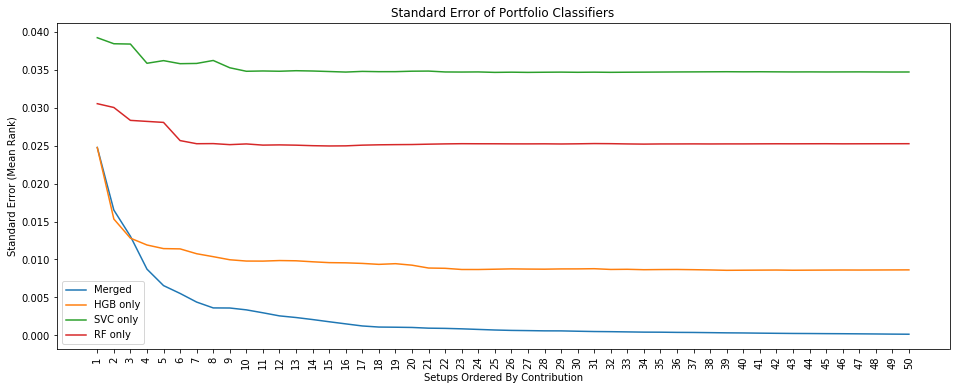

In [65]:
ax1 = pd.Series(pp_merged_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_hgb_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_svc_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_rf_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))


ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only', 'RF only'])
ax1.set_yscale('linear')
ax1.set_ylabel('Standard Error (Mean Rank)')
ax1.set_xlabel('Setups Ordered By Contribution')
ax1.set_title('Standard Error of Portfolio Classifiers')
;

In [66]:
setup_id, pp_merged_mean_rank, pp_merged_sem_rank = perf_imp(evals_merged_rank, evals_merged_std,
                                                            criterion='mean', ranking='min')
setup_id, pp_hgb_mean_rank, pp_hgb_sem_rank = perf_imp(evals_hgb_rank, evals_hgb_std,
                                                      criterion='mean', ranking='min')
setup_id, pp_svc_mean_rank, pp_svc_sem_rank = perf_imp(evals_svc_rank, evals_svc_std,
                                                      criterion='mean', ranking='min')
setup_id, pp_rf_mean_rank, pp_rf_sem_rank = perf_imp(evals_rf_rank, evals_rf_std,
                                                     criterion='mean', ranking='min')

''

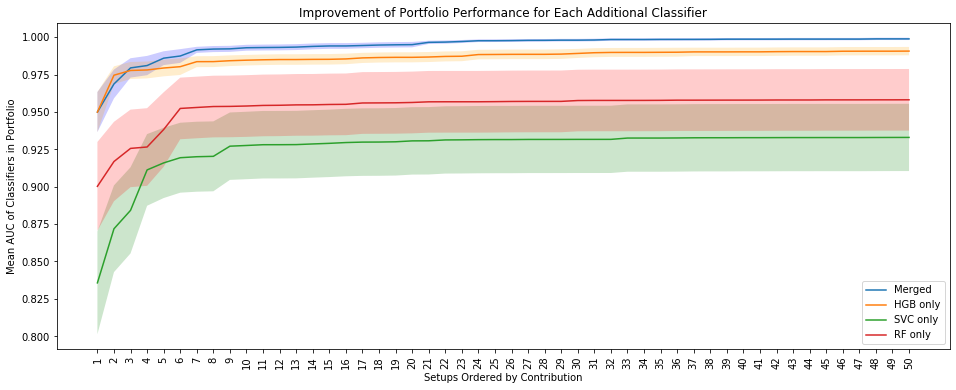

In [67]:
merged_rank_u = [i + j for i, j in zip(pp_merged_mean_rank[0:50], pp_merged_sem_rank[0:50])]
merged_rank_l = [i - j for i, j in zip(pp_merged_mean_rank[0:50], pp_merged_sem_rank[0:50])]
hgb_rank_u = [i + j for i, j in zip(pp_hgb_mean_rank[0:50], pp_hgb_sem_rank[0:50])]
hgb_rank_l = [i - j for i, j in zip(pp_hgb_mean_rank[0:50], pp_hgb_sem_rank[0:50])]
svc_rank_u = [i + j for i, j in zip(pp_svc_mean_rank[0:50], pp_svc_sem_rank[0:50])]
svc_rank_l = [i - j for i, j in zip(pp_svc_mean_rank[0:50], pp_svc_sem_rank[0:50])]
rf_rank_u = [i + j for i, j in zip(pp_rf_mean_rank[0:50], pp_rf_sem_rank[0:50])]
rf_rank_l = [i - j for i, j in zip(pp_rf_mean_rank[0:50], pp_rf_sem_rank[0:50])]

ax1 = pd.Series(pp_merged_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_hgb_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_svc_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_rf_mean_rank[0:50]).plot(figsize = (16,6), xticks=range(50))

ax1.fill_between(range(0,50), merged_rank_u, merged_rank_l, alpha=0.2, facecolor='blue')
ax1.fill_between(range(0,50), hgb_rank_u, hgb_rank_l, alpha=0.2, facecolor='orange')
ax1.fill_between(range(0,50), svc_rank_u, svc_rank_l, alpha=0.2, facecolor='green')
ax1.fill_between(range(0,50), rf_rank_u, rf_rank_l, alpha=0.2, facecolor='red')

ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only', 'RF only'])
ax1.set_yscale('linear')
ax1.set_ylabel('Mean AUC of Classifiers in Portfolio')
ax1.set_xlabel('Setups Ordered by Contribution')
ax1.set_title('Improvement of Portfolio Performance for Each Additional Classifier')
;

''

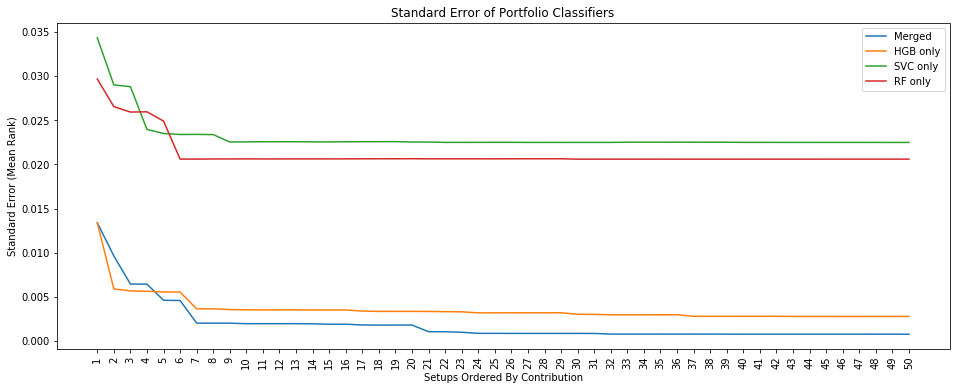

In [68]:
ax1 = pd.Series(pp_merged_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_hgb_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_svc_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))
ax1 = pd.Series(pp_rf_sem_rank[0:50]).plot(figsize = (16,6), xticks=range(50))


ax1.set_xticklabels(labels=range(1,51), rotation = 90)
ax1.legend(['Merged','HGB only','SVC only', 'RF only'])
ax1.set_yscale('linear')
ax1.set_ylabel('Standard Error (Mean Rank)')
ax1.set_xlabel('Setups Ordered By Contribution')
ax1.set_title('Standard Error of Portfolio Classifiers')
;


# Get model condigurations

## Merged portfolio by rank

In [69]:
# get ensemble of X setups
setup_list_merged_rank = sub_opt(evals_merged_rank, 31, criterion='mean', ranking='min')
print(setup_list_merged_rank)

[8166999, 8261540, 8255634, 8157210, 8255630, 8262236, 8157770, 8255853, 8255687, 8261570, 8154931, 8155425, 8157030, 8261733, 8261627, 8255920, 8255623, 8255596, 8157545, 8155977, 8155322, 8157452, 8255723, 8262109, 8255627, 8154288, 8261524, 8168865, 8155196, 8158182, 8261573, 8167220]


In [70]:
# get ensemble of X setups
setup_list_merged_rank = sub_opt(evals_merged_rank, 31, criterion='mean', ranking='min')
print(setup_list_merged_rank)

[8166999, 8261540, 8255634, 8157210, 8255630, 8262236, 8157770, 8255853, 8255687, 8261570, 8154931, 8155425, 8157030, 8261733, 8261627, 8255920, 8255623, 8255596, 8157545, 8155977, 8155322, 8157452, 8255723, 8262109, 8255627, 8154288, 8261524, 8168865, 8155196, 8158182, 8261573, 8167220]


In [71]:
algorithms = []
for i in setup_list_merged_rank:
    clf = openml.setups.initialize_model(i)[-1]
    clf_str = str(type(clf)).split('.')[-1].strip(string.punctuation)
    algorithms.append(clf_str)

In [72]:
pd.DataFrame(algorithms)

,0
0,HistGradientBoostingClassifier
1,RandomForestClassifier
2,SVC
3,HistGradientBoostingClassifier
4,SVC
5,RandomForestClassifier
6,HistGradientBoostingClassifier
7,SVC
8,SVC
9,RandomForestClassifier


In [73]:
pd.Series(algorithms).value_counts()


HistGradientBoostingClassifier    15
SVC                                9
RandomForestClassifier             8
dtype: int64

In [79]:
counter = 1
for i in setup_list_merged_rank:
    
    clf = openml.setups.initialize_model(i)[-1]
    
    if 'Hist' in str(type(clf)):
        print('HistGradientBoostingClassifier(l2_regularization='+str(clf.get_params()['l2_regularization'])+',\n',
             'learning_rate='+str(clf.get_params()['learning_rate'])+',',
             "loss='"+str(clf.get_params()['loss'])+"',\n",
             'max_bins='+str(clf.get_params()['max_bins'])+',',
             'max_depth='+str(clf.get_params()['max_depth'])+',\n',
             'max_iter='+str(clf.get_params()['max_iter'])+',',
             'max_leaf_nodes='+str(clf.get_params()['max_leaf_nodes'])+',\n',
             'min_samples_leaf='+str(clf.get_params()['min_samples_leaf'])+'),')
        
    elif 'SVC' in str(type(clf)):
        print('SVC(C='+str(clf.get_params()['C'])+',',
              'coef0='+str(clf.get_params()['coef0'])+',',
              'degree='+str(clf.get_params()['degree'])+',\n',
              'gamma='+str(clf.get_params()['gamma'])+',',
              "kernel='"+str(clf.get_params()['kernel'])+"',",
              'probability=False),')
        
    elif 'Random' in str(type(clf)):
        print('RandomForestClassifier(criterion='+str(clf.get_params()['criterion'])+',',
              'max_depth='+str(clf.get_params()['max_depth'])+',\n',
              'max_features='+str(clf.get_params()['max_features'])+',',
              'max_leaf_nodes='+str(clf.get_params()['max_leaf_nodes'])+',\n',
              'min_impurity_split='+str(clf.get_params()['min_impurity_split'])+',',
              'min_samples_leaf='+str(clf.get_params()['min_samples_leaf'])+',\n',
              'min_samples_split='+str(clf.get_params()['min_samples_split'])+',',
              'min_weight_fraction_leaf='+str(clf.get_params()['min_weight_fraction_leaf'])+',\n',
              'n_estimators='+str(clf.get_params()['n_estimators'])+',')
        
    print()
    counter += 1

HistGradientBoostingClassifier(l2_regularization=1e-06,
 learning_rate=0.1, loss='auto',
 max_bins=256, max_depth=None,
 max_iter=200, max_leaf_nodes=128,
 min_samples_leaf=50),

RandomForestClassifier(criterion=entropy, max_depth=None,
 max_features=0.32778941525789984, max_leaf_nodes=None,
 min_impurity_split=None, min_samples_leaf=1,
 min_samples_split=5, min_weight_fraction_leaf=0.0,
 n_estimators=300,

SVC(C=52.368035023140784, coef0=0.0, degree=3,
 gamma=0.008051730038808798, kernel='rbf', probability=False),

HistGradientBoostingClassifier(l2_regularization=1.0,
 learning_rate=0.1, loss='auto',
 max_bins=128, max_depth=8,
 max_iter=350, max_leaf_nodes=16,
 min_samples_leaf=4),

SVC(C=2.5918689981661567, coef0=0.3186996400686849, degree=3,
 gamma=0.0016271844595562733, kernel='rbf', probability=False),

RandomForestClassifier(criterion=entropy, max_depth=None,
 max_features=0.07198156955074353, max_leaf_nodes=None,
 min_impurity_split=None, min_samples_leaf=1,
 min_samples_split=

## HGB portfolio by rank

In [80]:
setup_list_hgb_rank = sub_opt(evals_hgb_rank, 31, criterion='mean', ranking='min')
print(setup_list_hgb_rank)

[8166999, 8158101, 8154931, 8158087, 8156960, 8156260, 8154370, 8155006, 8155405, 8154535, 8154704, 8154742, 8155748, 8156228, 8156853, 8155757, 8155137, 8157985, 8155577, 8156931, 8154713, 8157397, 8155061, 8155322, 8157910, 8155841, 8157828, 8154927, 8155196, 8156475, 8157367, 8154465]


In [81]:
counter = 1
for i in setup_list_hgb_rank:

    clf = openml.setups.initialize_model(i)[-1]
    print('HistGradientBoostingClassifier(l2_regularization='+str(clf.get_params()['l2_regularization'])+',\n',
         'learning_rate='+str(clf.get_params()['learning_rate'])+',',
         "loss='"+str(clf.get_params()['loss'])+"',",
         'max_bins='+str(clf.get_params()['max_bins'])+',',
         'max_depth='+str(clf.get_params()['max_depth'])+',\n',
         'max_iter='+str(clf.get_params()['max_iter'])+',',
         'max_leaf_nodes='+str(clf.get_params()['max_leaf_nodes'])+',',
         'min_samples_leaf='+str(clf.get_params()['min_samples_leaf'])+'),')
    counter += 1

HistGradientBoostingClassifier(l2_regularization=1e-06,
 learning_rate=0.1, loss='auto', max_bins=256, max_depth=None,
 max_iter=200, max_leaf_nodes=128, min_samples_leaf=50),
HistGradientBoostingClassifier(l2_regularization=1.0,
 learning_rate=0.1, loss='auto', max_bins=64, max_depth=5,
 max_iter=100, max_leaf_nodes=4, min_samples_leaf=1),
HistGradientBoostingClassifier(l2_regularization=1.0,
 learning_rate=0.1, loss='auto', max_bins=64, max_depth=18,
 max_iter=350, max_leaf_nodes=32, min_samples_leaf=7),
HistGradientBoostingClassifier(l2_regularization=1e-07,
 learning_rate=0.1, loss='auto', max_bins=16, max_depth=19,
 max_iter=500, max_leaf_nodes=8, min_samples_leaf=27),
HistGradientBoostingClassifier(l2_regularization=10.0,
 learning_rate=0.1, loss='auto', max_bins=256, max_depth=16,
 max_iter=100, max_leaf_nodes=128, min_samples_leaf=8),
HistGradientBoostingClassifier(l2_regularization=1e-07,
 learning_rate=0.1, loss='auto', max_bins=256, max_depth=16,
 max_iter=350, max_leaf_node

## SVC portfolio by rank

In [82]:
setup_list_svc_rank = sub_opt(evals_svc_rank, 31, criterion='mean', ranking='min')
print(setup_list_svc_rank)

[8255634, 8255569, 8255546, 8255660, 8255687, 8255559, 8255619, 8255617, 8255808, 8255598, 8256151, 8255513, 8255724, 8255605, 8255732, 8255878, 8255723, 8255853, 8255829, 8255924, 8255596, 8255939, 8255661, 8255612, 8255861, 8255640, 8255556, 8255862, 8255759, 8255610, 8255951, 8255699]


In [83]:
counter = 1
for i in setup_list_svc_rank:
    
    clf = openml.setups.initialize_model(i)[-1]

    print('SVC(C='+str(clf.get_params()['C'])+',',
         'coef0='+str(clf.get_params()['coef0'])+',',
         'degree='+str(clf.get_params()['degree'])+',\n',
         'gamma='+str(clf.get_params()['gamma'])+',',
         "kernel='"+str(clf.get_params()['kernel'])+"',",
         'probability=False),')
    counter += 1

SVC(C=52.368035023140784, coef0=0.0, degree=3,
 gamma=0.008051730038808798, kernel='rbf', probability=False),
SVC(C=149.07622270551335, coef0=0.0, degree=3,
 gamma=0.05610768111553853, kernel='rbf', probability=False),
SVC(C=1.68536554317688, coef0=0.2168646578884883, degree=3,
 gamma=0.0008080068502590277, kernel='rbf', probability=False),
SVC(C=81.8664880584341, coef0=0.1339044447397313, degree=4,
 gamma=0.6339071538529285, kernel='rbf', probability=False),
SVC(C=1.799125831143992, coef0=0.7926565732345652, degree=3,
 gamma=0.01858955180141993, kernel='poly', probability=False),
SVC(C=55762.3529353618, coef0=-0.8056114085510306, degree=3,
 gamma=3.187772482265977e-05, kernel='sigmoid', probability=False),
SVC(C=34.18479740302528, coef0=0.465809282171058, degree=3,
 gamma=0.025017141595224057, kernel='rbf', probability=False),
SVC(C=4.104647380564808, coef0=-0.724712336449596, degree=5,
 gamma=0.2926981232494074, kernel='rbf', probability=False),
SVC(C=1.0357760788047117, coef0=0.4208

## RF portfolio by rank

In [84]:
setup_list_rf_rank = sub_opt(evals_rf_rank, 31, criterion='mean', ranking='min')
print(setup_list_rf_rank)

[8261522, 8261928, 8262150, 8261754, 8262277, 8261901, 8262089, 8261708, 8261674, 8261576, 8261588, 8261862, 8261602, 8261567, 8261806, 8261759, 8261740, 8261817, 8261710, 8261524, 8262261, 8261896, 8261514, 8261688, 8261583, 8262236, 8262053, 8262023, 8261558, 8261769, 8261778, 8261787]


In [85]:
counter = 1
for i in setup_list_rf_rank:
    
    clf = openml.setups.initialize_model(i)[-1]

    print('RandomForestClassifier(criterion='+str(clf.get_params()['criterion'])+',',
          'max_depth='+str(clf.get_params()['max_depth'])+',\n',
          'max_features='+str(clf.get_params()['max_features'])+',',
          'max_leaf_nodes='+str(clf.get_params()['max_leaf_nodes'])+',\n',
          'min_impurity_split='+str(clf.get_params()['min_impurity_split'])+',',
          'min_samples_leaf='+str(clf.get_params()['min_samples_leaf'])+',\n',
          'min_samples_split='+str(clf.get_params()['min_samples_split'])+',',
          'min_weight_fraction_leaf='+str(clf.get_params()['min_weight_fraction_leaf'])+',\n',
          'n_estimators='+str(clf.get_params()['n_estimators'])+',')
    counter += 1

RandomForestClassifier(criterion=entropy, max_depth=None,
 max_features=0.13891783454814322, max_leaf_nodes=None,
 min_impurity_split=None, min_samples_leaf=2,
 min_samples_split=9, min_weight_fraction_leaf=0.0,
 n_estimators=300,
RandomForestClassifier(criterion=gini, max_depth=None,
 max_features=0.050069426976632525, max_leaf_nodes=None,
 min_impurity_split=None, min_samples_leaf=1,
 min_samples_split=3, min_weight_fraction_leaf=0.0,
 n_estimators=500,
RandomForestClassifier(criterion=entropy, max_depth=None,
 max_features=0.38146409165028106, max_leaf_nodes=None,
 min_impurity_split=None, min_samples_leaf=1,
 min_samples_split=12, min_weight_fraction_leaf=0.0,
 n_estimators=300,
RandomForestClassifier(criterion=entropy, max_depth=None,
 max_features=0.20254434685778855, max_leaf_nodes=None,
 min_impurity_split=None, min_samples_leaf=1,
 min_samples_split=3, min_weight_fraction_leaf=0.0,
 n_estimators=500,
RandomForestClassifier(criterion=gini, max_depth=None,
 max_features=0.093710

# Compare portfolios

In [86]:
task_perf_merged = evals_wide_merged.loc[setup_list_merged_rank,:].max()
task_perf_hgb = evals_wide_merged.loc[setup_list_hgb_rank,:].max()
task_perf_svc = evals_wide_merged.loc[setup_list_svc_rank,:].max()
task_perf_rf = evals_wide_merged.loc[setup_list_rf_rank,:].max()


In [87]:
task_perf_comp = pd.concat([task_perf_merged, task_perf_hgb, task_perf_svc, task_perf_rf], axis=1)

In [88]:
task_perf_comp = task_perf_comp.rename(columns={0: 'merged', 1: 'hgb', 2: 'svc', 3: 'rf'})

In [89]:
task_perf_comp = task_perf_comp.fillna(0.5)

In [90]:
task_perf_comp.describe()

,merged,hgb,svc,rf
count,68.000000,68.000000,68.000000,68.000000
mean,0.934461,0.931670,0.905790,0.916124
std,0.101171,0.102974,0.131517,0.124634
min,0.530643,0.529776,0.500000,0.500000
25%,0.924849,0.923018,0.841520,0.908744
50%,0.985011,0.983388,0.968962,0.963724
75%,0.999399,0.998734,0.999151,0.998014
max,1.000000,1.000000,1.000000,0.999969


In [91]:
task_perf_comp_rank = task_perf_comp.rank(axis=1, method='min', ascending=False)

In [92]:
task_perf_comp_rank.describe()

,merged,hgb,svc,rf
count,68.000000,68.000000,68.000000,68.000000
mean,1.323529,2.411765,2.720588,3.029412
std,0.530873,1.040024,1.336576,1.006999
min,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.750000,1.000000,3.000000
50%,1.000000,2.500000,3.000000,3.000000
75%,2.000000,3.000000,4.000000,4.000000
max,3.000000,4.000000,4.000000,4.000000


In [93]:
task_perf_comp_rank.melt()

,variable,value
0,merged,1.0
1,merged,1.0
2,merged,1.0
3,merged,1.0
4,merged,2.0
...,...,...
267,rf,4.0
268,rf,4.0
269,rf,3.0
270,rf,4.0


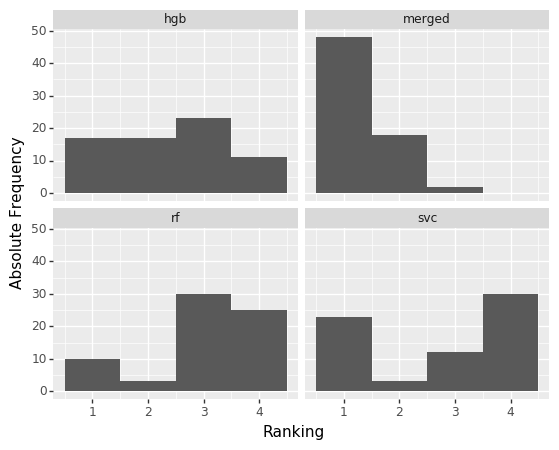

<ggplot: (7547273550)>

In [94]:
(ggplot(task_perf_comp_rank.melt()) +
 aes(x='value') + 
 geom_histogram(bins=4) +
 facet_wrap('variable') +
 xlab('Ranking') +
 ylab('Absolute Frequency')
)

In [95]:
rank_mean = task_perf_comp_rank.mean()
rank_sem = task_perf_comp_rank.sem()

Text(0, 0.5, 'Mean rank')

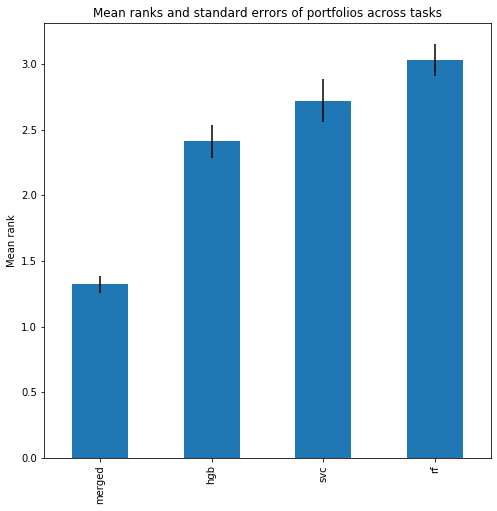

In [96]:
ax = rank_mean.plot(kind='bar', yerr=rank_sem, figsize=(8,8))
ax.set_title('Mean ranks and standard errors of portfolios across tasks')
ax.set_ylabel('Mean rank')

In [97]:
task_perf_comp_rank.sem()

merged    0.064378
hgb       0.126121
svc       0.162084
rf        0.122117
dtype: float64

In [98]:
AUC_mean = task_perf_comp.mean()
AUC_sem = task_perf_comp.sem()

Text(0, 0.5, 'Mean AUC')

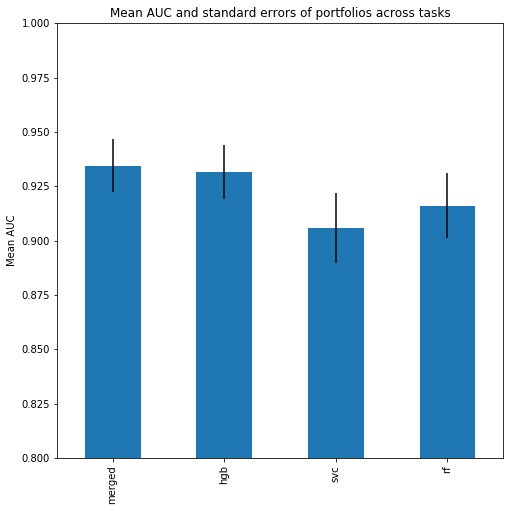

In [101]:
ax = AUC_mean.plot(kind='bar', yerr=AUC_sem, figsize=(8,8), ylim=(0.8,1))
ax.set_title('Mean AUC and standard errors of portfolios across tasks')
ax.set_ylabel('Mean AUC')